In [19]:
import numpy as np
import math
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle

transform = transforms.Compose(
  [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                    download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                      shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                      shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
        'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#getting the x(2d matrix of 50000*3072, input images), and y(1*3072, output label);
tmpTrain = trainloader.dataset.data # shape of 50000*32*32*3 need to transform to 50000*3072
x,y1,y2,y3 = tmpTrain.shape
trainX = np.zeros([x, y1*y2*y3])
tmpTrainY = trainloader.dataset.targets
trainY = np.zeros([len(tmpTrainY), len(classes)])
for i in range(len(tmpTrainY)):
  trainY[i][tmpTrainY[i]] = 1
tmpTest = testloader.dataset.data # shape of 10000*32*32*3 need to transform to 10000*3072
xx, y4, y5, y6 = tmpTest.shape
testY = testloader.dataset.targets
testX = np.zeros([xx, y4*y5*y6])
for i in range(x):
  trainX[i] = tmpTrain[i].flatten()

trainX = trainX / np.linalg.norm(trainX) 
for j in range(xx):
  testX[j] = tmpTest[j].flatten()

testX = testX / np.linalg.norm(testX)

print("the shape of matrix trainX" + str(trainX.shape))
print("the size of trainY " + str(trainY.shape))
print("the shape of matrix testX" + str(testX.shape))
print("the size of testY " + str(len(testY)))

class MLP():
  Ws = [] #weights
  Zs = [] #hidden layers
  AV = []#activation function

  #use to graph the training and testing accuracy in function of epoch
  xGraph = []
  trainYGraph = []
  testYGraph = []

  #activation functions

  def softmax(self,x):
    N,D = x.shape
    x_exp = np.exp(x - np.max(x, 1)[:, None])
    return x_exp / np.sum(x_exp, axis=-1)[:, None]

  def relu(self,x):
    N, D = x.shape
    ans = np.zeros([N,D])
    for i in range(N):
      for j in range(D):
        if x[i][j] > 0:
          ans[i][j] = x[i][j]
        else:
          ans[i][j] = 0
    return ans

  def sigmoid(self,x):
    N, D = x.shape
    ans = np.zeros([N,D])
    for i in range(N):
      for j in range(D):
        try:
          ans[i][j] = 1/(1+math.exp(-x[i][j]))
        except OverflowError:
          if(x[i][j])>0:
            ans[i][j] = 1
          else:
            ans[i][j] = 0
    return ans

  def getYhead(self,X):
    Y = []
    N,D = X.shape
    self.Zs.clear()
    for layer in layerNumber:
      self.Zs.append(np.zeros([N,layer]))
    Yhead = np.zeros([N, 10])
    tmp = X
    for i in range(len(self.Ws)-1):
      NN,DD = tmp.shape
      tmp = self.relu(np.dot(tmp, self.Ws[i])) #Doing activation function for the Zs in layer
      self.Zs[i] = tmp
    Y = self.softmax(np.dot(tmp, self.Ws[len(self.Ws)-1])) #Doing softmax for final layer since it is multiclass classification
    return Y

  #Cost of one training result
  def cost(self,Y1, Y2):
    total = 0.0
    for i in range(len(Y1)):
      value = (Y1[i]-Y2[i])*(Y1[i]-Y2[i])
      total = total + value
    return total

  #Average cost of all training result
  def averageCost(self,Y1, Y2):
    N,D = Y1.shape
    total = 0.0
    for i in range(N):
      total = total + self.cost(Y1[i],Y2[i])
    return total/N

  def gradient(self,X, Y):
    N,D = X.shape
    Yh = self.getYhead(X)
    print("Average cost so far " + str(self.averageCost(Yh, Y)))
    dY = (Yh - Y)
    dZnext =dY
    WsReversed = self.Ws.copy()
    ZsReversed = self.Zs.copy()
    WsReversed.reverse() #reverse them since we need to calculate the dw from last layer to the first layer
    ZsReversed.reverse()
    dWs =[]
    w = WsReversed[0]
    z = ZsReversed[0]
    dW = np.dot(z.T, dZnext)
    #Probably the problem come from here, I am trying to calculate the dWeight between last hidden layer and final layer
    #now z is the last hidden layer, Yh is the final answer, in the video, derivative of w = al-1*(derivative of sigmoid)*dy
    #al-1 is last hidden layer, Yh*(1-Yh) is the derivative of sigmoid, and dzNext is dy, however if Yh is all zero them dW
    #would be zero and if will keeps like that, and I was like what???
    dZnext = np.dot(dZnext, w.T)
    dWs.append(dW)
    for i in range(1, len(WsReversed)):
      w = WsReversed[i]
      zPrevious = ZsReversed[i-1]
      if i >= len(ZsReversed):
        z = X.copy()
      else:
        z = ZsReversed[i]
      Zn, Zd = zPrevious.shape
      tmp = np.zeros([Zn,Zd])
      for i in range(Zn):
        for j in range(Zd):
          if zPrevious[i][j]>0:
            tmp[i][j] = 1
      dW = np.dot(z.T, dZnext*tmp)
      dZnext = np.dot(dZnext*tmp, w.T)
      dWs.append(dW)
    dWs.reverse()
    return dWs

  def fit(self,layerNumber, trainX, trainY, testX, testY, lr, decay, eps, maxiterations, bsize, beta):
    #fill Ws with initial random weight
    #define weights for different layers, put them in a list called Ws, each weight has a shape of size(l-1)*size(l)
    N,D = trainX.shape
    start = D
    N,DD =trainY.shape
    end = layerNumber[0]
    w = np.random.randn(start, end)*0.1
    self.Ws.append(w)
    for i in range(len(layerNumber)):
      start = layerNumber[i]
      if i+1 == len(layerNumber):
        end = DD
      else:
        end = layerNumber[i+1]
      w = np.random.randn(start, end)*0.1
      #print(w)
      self.Ws.append(w)
    dW = np.inf*np.ones_like(self.Ws[len(self.Ws)-1])
    dws = []
    for w in self.Ws:
      dw = np.zeros(w.shape)
      dws.append(dw)
    iter = 0
    epoch = 0

    while np.linalg.norm(dW) > eps and iter<maxiterations:
      Num = N/bsize # we must run Num time iterations to get one epoch
      for n in range(int(Num)):
        start = n*bsize
        end = start+bsize
        g = self.gradient(trainX[start:end,:], trainY[start:end,:])
        for i in range(len(self.Ws)):
          dws[i] = (1-beta)*g[i]+beta*dws[i]
          self.Ws[i] = self.Ws[i]-lr*dws[i]
        dW = g[len(self.Ws)-1]
        print(iter)
        lr *= (1. / (1. + decay * iter))
        iter = iter+1
      epoch = epoch+1
      trainingAccuracy = self.predict(trainX, tmpTrainY)
      testingAccuracy = self.predict(testX, testY)
      self.xGraph.append(epoch)
      self.trainYGraph.append(trainingAccuracy)
      self.testYGraph.append(testingAccuracy)
      print("Epoch " + str(epoch) + ": training accuracy " + str(trainingAccuracy) + ", testing accuracy " + str(testingAccuracy))
    
    self.xGraph = np.array(self.xGraph)
    self.trainYGraph = np.array(self.trainYGraph)
    self.testYGraph = np.array(self.testYGraph)

  def getBiggestY(self, Y):
    #print(Y) 
    N,D = Y.shape
    result = np.zeros([N])
    for i in range(N):
      biggest = 0
      biggestNum = 0
      for j in range(D):
        if Y[i][j]>biggest:
          biggestNum = j
          biggest = Y[i][j]
        result[i] = biggestNum
    print(result)
    return result

  def predict(self, testX, testY):
    print("predicting ...")
    yHead = self.getYhead(testX)
    yResult = self.getBiggestY(yHead)
    totalRight = 0.0
    for i in range(len(testY)):
      if(yResult[i] == testY[i]):
        totalRight = totalRight+1
    return totalRight/len(testY)


layerNumber = [800, 200, 50] #number of hidden layers and number of nodes in each layer
theMLP = MLP()
theMLP.fit(layerNumber, trainX, trainY, testX, testY, 0.1, 0.0000005, 1e-09, 5000, 1000, 0.99)
print(theMLP.predict(testX, testY))



Streaming output truncated to the last 5000 lines.
Average cost so far 0.6907663184141956
2527
Average cost so far 0.6980965798787884
2528
Average cost so far 0.6687890973656251
2529
Average cost so far 0.689965852824206
2530
Average cost so far 0.6688647890094407
2531
Average cost so far 0.6894416129964821
2532
Average cost so far 0.7137392774325757
2533
Average cost so far 0.6983575128015573
2534
Average cost so far 0.6480250239920984
2535
Average cost so far 0.6693709160704253
2536
Average cost so far 0.6993301015546324
2537
Average cost so far 0.7239802961484313
2538
Average cost so far 0.6888597332115758
2539
Average cost so far 0.6972476164797119
2540
Average cost so far 0.6909880311260808
2541
Average cost so far 0.6811848008817992
2542
Average cost so far 0.6776702422397223
2543
Average cost so far 0.7463489750573084
2544
Average cost so far 0.7331618741312285
2545
Average cost so far 0.7035697690117163
2546
Average cost so far 0.7071956489604472
2547
Average cost so far 0.6782

In [20]:
yHead = theMLP.getYhead(testX)
yResult = theMLP.getBiggestY(yHead)
totalCorrect = np.zeros(10)
predictCorrect = np.zeros(10)
for i in range(len(testY)):
  totalCorrect[testY[i]] += 1
  if yResult[i] == testY[i]:
    predictCorrect[int(yResult[i])]+=1
for i in range(10):
  print(classes[i] + " accuracy: " + str(predictCorrect[i]/totalCorrect[i]))

[3. 9. 8. ... 5. 6. 7.]
plane accuracy: 0.534
car accuracy: 0.59
bird accuracy: 0.274
cat accuracy: 0.248
deer accuracy: 0.31
dog accuracy: 0.385
frog accuracy: 0.609
horse accuracy: 0.563
ship accuracy: 0.637
truck accuracy: 0.517


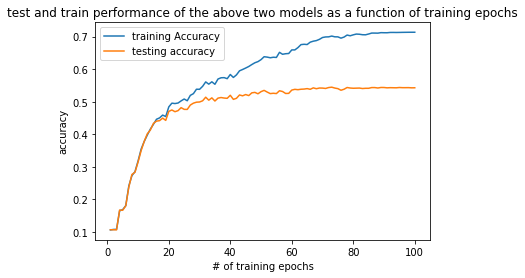

In [16]:
theMLP.xGraph = np.array(theMLP.xGraph)
theMLP.trainYGraph = np.array(theMLP.trainYGraph)
theMLP.testYGraph = np.array(theMLP.testYGraph)

import matplotlib.pyplot as plt 
  
# line 1 points 
x1 = theMLP.xGraph
y1 = theMLP.trainYGraph
# plotting the line 1 points  
plt.plot(x1, y1, label = "training Accuracy") 
  
# line 2 points 
x2 = theMLP.xGraph
y2 = theMLP.testYGraph 
# plotting the line 2 points  
plt.plot(x2, y2, label = "testing accuracy") 
  
# naming the x axis 
plt.xlabel('# of training epochs') 
# naming the y axis 
plt.ylabel('accuracy') 
# giving a title to my graph 
plt.title('test and train performance of the above two models as a function of training epochs') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 
